In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from source.transf_univ import df_scaler
from sklearn.metrics import silhouette_score

pd.set_option("max_columns", 300)

In [2]:
events_m = pd.read_csv('data/processed_men/events_extended.csv')
events_w = pd.read_csv('data/processed_women/events_extended.csv')

for col in [col for col in events_m if 'W' in col and ('_half2' in col or '_crunchtime' in col)]:
    name = col.replace('W', '')
    events_m[name+'_diff'] = events_m['W' + name] - events_m['L' + name]
    events_w[name+'_diff'] = events_w['W' + name] - events_w['L' + name]

events_m.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Wtop_team,Wupset,WOT_win,WAway,WFG_perc,WFGM2,WFGA2,WFG2_perc,WFG3_perc,WFT_perc,WTot_Reb,WFGM_no_ast,WFGM_no_ast_perc,Wpossessions,Woff_rating,Wshtg_opportunity,WTO_perposs,WTrue_shooting_perc,LFG_perc,LFGM2,LFGA2,LFG2_perc,LFG3_perc,LFT_perc,LTot_Reb,LFGM_no_ast,LFGM_no_ast_perc,Lpossessions,Loff_rating,Lshtg_opportunity,LTO_perposs,LTrue_shooting_perc,Wdef_rating,Ldef_rating,Wopp_shtg_opportunity,Lopp_shtg_opportunity,Wopp_possessions,Lopp_possessions,Wopp_score,Lopp_score,Wopp_FTA,Wopp_FGA,Lopp_FTA,Lopp_FGA,Wimpact,Limpact,WDR_opportunity,LDR_opportunity,WOR_opportunity,LOR_opportunity,Score_diff,Score_advantage,FGM_diff,FGM_advantage,FGA_diff,FGA_advantage,FGM3_diff,FGM3_advantage,FGA3_diff,FGA3_advantage,FTM_diff,FTM_advantage,FTA_diff,FTA_advantage,OR_diff,OR_advantage,DR_diff,DR_advantage,Ast_diff,Ast_advantage,TO_diff,TO_advantage,Stl_diff,Stl_advantage,Blk_diff,Blk_advantage,PF_diff,PF_advantage,FGM2_diff,FGM2_advantage,FGA2_diff,FGA2_advantage,Tot_Reb_diff,Tot_Reb_advantage,FGM_no_ast_diff,FGM_no_ast_advantage,DR_opportunity_diff,DR_opportunity_advantage,OR_opportunity_diff,OR_opportunity_advantage,possessions_diff,possessions_advantage,off_rating_diff,off_rating_advantage,def_rating_diff,def_rating_advantage,shtg_opportunity_diff,shtg_opportunity_advantage,TO_perposs_diff,TO_perposs_advantage,impact_diff,impact_advantage,True_shooting_perc_diff,True_shooting_perc_advantage,tourney,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime,competitive,points_made_half2_diff,points_made_crunchtime_diff,made1_half2_diff,made2_half2_diff,made3_half2_diff,reb_half2_diff,turnover_half2_diff,assist_half2_diff,steal_half2_diff,block_half2_diff,made1_crunchtime_diff,made2_crunchtime_diff,made3_crunchtime_diff,reb_crunchtime_diff,turnover_crunchtime_diff,assist_crunchtime_diff,steal_crunchtime_diff,block_crunchtime_diff,Ast_perc_half2_diff,FGM_perc_half2_diff,FGM3_perc_half2_diff,FTM_perc_half2_diff,Ast_perc_crunchtime_diff,FGM_perc_crunchtime_diff,FGM3_perc_crunchtime_diff,FTM_perc_crunchtime_diff
0,2015,11,1103,74,1420,57,H,0,25,53,12,30,12,21,9,25,17,12,7,5,22,20,48,3,12,14,28,12,23,13,16,9,0,19,0.0,0.0,0,0,0.471698,13,23,0.565217,0.400000,0.571429,34,8,0.320000,65.975,112.163698,0.954528,0.181887,0.587535,0.416667,17,36,0.472222,0.250000,0.500000,35,7,0.350000,65.300,87.289433,0.938744,0.245023,0.464927,87.289433,112.163698,0.938744,0.954528,65.300,65.975,57,74,28,48,21,53,0.601695,0.398305,0.892857,0.821429,0.321429,0.428571,17,1,5,1,5,1,9,1,18,1,-2,0,-7,0,-3,0,2,1,4,1,-4,0,-2,0,5,1,3,1,-4,0,-13,0,-1,0,1,1,0.071429,1,-0.107143,0,0.675,1,24.874265,1,-24.874265,0,0.015784,1,-0.063136,0,0.203390,1,0.122608,1,0,12,0,0.0,37.0,31.0,3.0,11.0,5,12,4,8,8,1,23,23,7,6,9,7,2,7,4,0,1,4,1,2,0,1,1,7,1,1,0,2,0,1,1,0,0.750000,0.777778,0.480000,0.375000,0.500000,0.250000,0.416667,0.521739,0.000000,0.666667,0.200000,0.75,0.000000,1.0,0.500000,0.666667,0,6.0,-8.0,-7,-4,7,0,1,2,-5,4,-3,-1,-1,-6,0,-2,-1,1,-0.027778,0.

In [3]:
events_m['Ast_perc_crunchtime_diff'] = events_m['Ast_perc_crunchtime_diff'].replace(np.inf, 0).replace(-np.inf, 0)
events_w['Ast_perc_crunchtime_diff'] = events_w['Ast_perc_crunchtime_diff'].replace(np.inf, 0).replace(-np.inf, 0)

In [5]:
to_use = ['Season', 'DayNum', 'tourney'] + [col for col in events_m if '_diff' in col]

pipe = Pipeline([('scaler', df_scaler()), ('aggl', AgglomerativeClustering())])

pipe.fit(events_m[to_use])

Pipeline(memory=None,
         steps=[('scaler', df_scaler(method='standard')),
                ('aggl',
                 AgglomerativeClustering(affinity='euclidean',
                                         compute_full_tree='auto',
                                         connectivity=None,
                                         distance_threshold=None,
                                         linkage='ward', memory=None,
                                         n_clusters=2))],
         verbose=False)

In [7]:
events_m['cluster'] = pipe.steps[-1][1].labels_
events_m.groupby(['cluster']).competitive.mean()

cluster
0    0.38397
1    0.02220
Name: competitive, dtype: float64

In [9]:
pipe.steps[-1][1].n_connected_components_

1

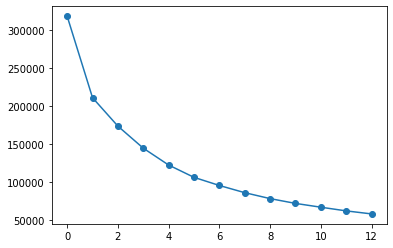

In [232]:
to_use = ['Season', 'DayNum', 'tourney'] + [col for col in events_m if '_diff' in col]

elbow = []
silouette = []

for cluster in np.arange(2, 15):
    tmp = events_m.copy()
    pipe = Pipeline([('scaler', df_scaler()), 
                     ('pca', PCA(n_components=2))])
    tmp = pipe.fit_transform(events_m[to_use])
    kmeans = KMeans(n_clusters=cluster, n_init=10, n_jobs=5).fit(tmp)
    elbow.append(kmeans.inertia_)
    silouette.append(silhouette_score(tmp, kmeans.labels_))

pd.Series(elbow).plot(marker='o')

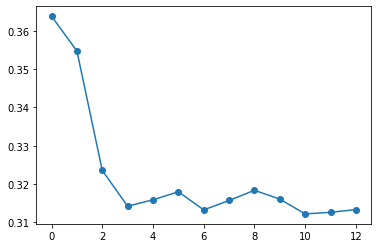

In [233]:
pd.Series(silouette).plot(marker='o')

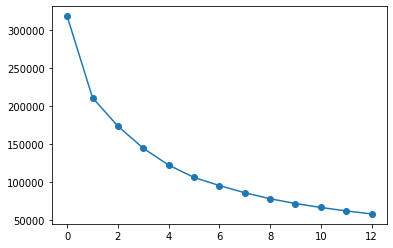

In [234]:
to_use = ['Season', 'DayNum', 'tourney'] + [col for col in events_m if '_diff' in col]

elbow = []
silouette = []

for cluster in np.arange(2, 15):
    tmp = events_m.copy()
    pipe = Pipeline([('scaler', df_scaler()), 
                     ('pca', PCA(n_components=2))])
    tmp = pipe.fit_transform(events_m[to_use])
    kmeans = KMeans(n_clusters=cluster, n_init=10, n_jobs=5).fit(tmp)
    elbow.append(kmeans.inertia_)
    silouette.append(silhouette_score(tmp, kmeans.labels_))

pd.Series(elbow).plot(marker='o')

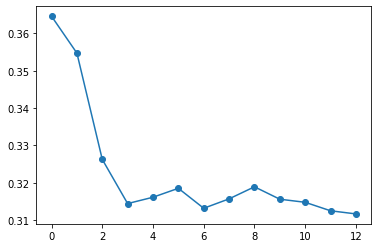

In [235]:
pd.Series(silouette).plot(marker='o')

In [244]:
pipe = Pipeline([('scaler', df_scaler()), 
                     ('pca', PCA(n_components=2))])
tmp = pipe.fit_transform(events_m[to_use])
kmeans = KMeans(n_clusters=3, n_init=10, n_jobs=5).fit(tmp)
events_m['cluster'] = kmeans.labels_
events_m.groupby(['cluster']).competitive.mean()

cluster
0    0.039240
1    0.485178
2    0.355643
Name: competitive, dtype: float64

0.3273130057536691


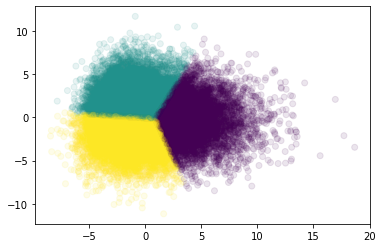

In [245]:
print(events_m.competitive.mean())
plt.scatter(tmp[:, 0], tmp[:, 1], c=kmeans.labels_, alpha=0.1)

In [246]:
pipe = Pipeline([('scaler', df_scaler()), 
                     ('pca', PCA(n_components=2))])
tmp = pipe.fit_transform(events_w[to_use])
kmeans = KMeans(n_clusters=3, n_init=10, n_jobs=5).fit(tmp)
events_w['cluster'] = kmeans.labels_
events_w.groupby(['cluster']).competitive.mean()

cluster
0    0.286432
1    0.372049
2    0.019670
Name: competitive, dtype: float64

0.250794054122729


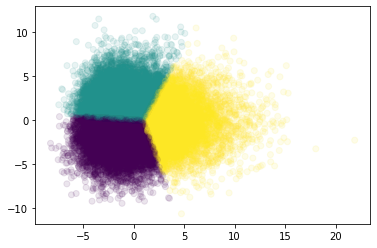

In [247]:
print(events_w.competitive.mean())
plt.scatter(tmp[:, 0], tmp[:, 1], c=kmeans.labels_, alpha=0.1)

In [39]:
events_m[(events_m.cluster == 5) & (events_m.competitive == 0)][to_use]

,Season,DayNum,tourney,game_lc,half2_lc,crunchtime_lc,Score_diff,FGM_diff,FGA_diff,FGM3_diff,FGA3_diff,FTM_diff,FTA_diff,OR_diff,DR_diff,Ast_diff,TO_diff,Stl_diff,Blk_diff,PF_diff,FGM2_diff,FGA2_diff,Tot_Reb_diff,FGM_no_ast_diff,DR_opportunity_diff,OR_opportunity_diff,possessions_diff,off_rating_diff,def_rating_diff,shtg_opportunity_diff,TO_perposs_diff,impact_diff,True_shooting_perc_diff
491,2015,20,0,12,7,1.0,5,2,3,2,-1,-1,-3,2,2,-4,0,-3,0,2,0,4,4,6,0.106154,0.064615,-0.425,8.502213,-8.502213,0.030554,0.001780,0.000000,0.029022
1295,2015,38,0,16,9,2.0,8,8,4,0,-12,-8,-10,-1,3,2,-1,-4,1,6,8,16,2,6,-0.005952,0.011905,-0.750,13.622254,-13.622254,-0.000886,-0.012976,0.062500,0.074379
1391,2015,41,0,14,6,2.0,6,0,12,-3,1,9,8,9,-4,-8,-5,6,2,-3,3,11,5,8,0.174937,0.148865,1.800,5.521280,-5.521280,0.183357,-0.069771,-0.018051,-0.071237
2006,2015,59,0,11,6,0.0,5,5,2,3,-5,-8,-16,-5,0,2,2,-4,-2,6,2,7,-5,3,-0.094286,-0.152857,1.400,5.284383,-5.284383,-0.112101,0.029387,0.035857,0.090292
2077,2015,61,0,18,10,0.0,6,-3,1,4,6,8,5,-2,-2,-3,-7,2,-1,2,-7,-5,-4,0,0.046897,-0.124138,-1.625,11.855043,-11.855043,0.074852,-0.102050,-0.011236,0.017404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31717,2020,117,0,15,7,0.0,4,0,2,-1,8,5,0,0,2,3,0,-2,5,-1,1,-6,2,-3,0.111235,-0.033370,2.000,2.657930,-2.657930,0.000798,-0.006779,0.109312,0.013229
31904,2020,121,0,17,6,2.0,4,3,0,-1,-3,-1,-2,2,6,0,2,2,-1,-2,4,3,8,3,0.115152,0.087879,-0.950,7.781607,-7.781607,-0.000967,0.034800,0.167421,0.042070
32081,2020,124,0,17,10,2.0,4,2,-5,3,7,-3,-5,-6,2,3,3,0,2,2,-1,-12,-4,-1,-0.101868,-0.122241,1.625,4.026699,-4.026699,-0.147937,0.045519,0.128440,0.089538
32152,2020,128,0,9,8,2.0,4,1,4,-2,-3,4,4,6,3,-2,0,1,-7,4,3,7,9,3,0.169697,0.169697,-0.100,6.600582,-6.600582,0.096826,0.000366,-0.013699,-0.013584


In [42]:
events_m.loc[events_m.cluster == 5, 'competitive'] = 1

In [41]:
events_w[(events_w.cluster == 1) & (events_w.competitive == 0)][to_use]

,Season,DayNum,tourney,game_lc,half2_lc,crunchtime_lc,Score_diff,FGM_diff,FGA_diff,FGM3_diff,FGA3_diff,FTM_diff,FTA_diff,OR_diff,DR_diff,Ast_diff,TO_diff,Stl_diff,Blk_diff,PF_diff,FGM2_diff,FGA2_diff,Tot_Reb_diff,FGM_no_ast_diff,DR_opportunity_diff,OR_opportunity_diff,possessions_diff,off_rating_diff,def_rating_diff,shtg_opportunity_diff,TO_perposs_diff,impact_diff,True_shooting_perc_diff
242,2015,14,0,18.0,3.0,2.0,4,2,6,3,8,-3,-1,-2,-7,4,-8,4,3,3,-1,-2,-9,-2,-0.145246,-0.119122,-0.475,6.842127,-6.842127,0.090669,-0.119581,-0.024221,-0.017772
296,2015,16,0,13.0,6.0,0.0,6,3,3,-2,-3,2,-3,-4,-7,-3,-3,1,-3,0,5,6,-11,6,-0.205882,-0.117647,2.575,4.604629,-4.604629,-0.010923,-0.048025,-0.012245,0.030188
361,2015,17,0,9.0,6.0,0.0,6,0,1,-1,-6,7,9,1,2,-2,-1,-4,2,-7,1,7,3,2,0.086022,0.018280,3.275,3.971389,-3.971389,0.031343,-0.026017,0.061224,0.003790
432,2015,19,0,14.0,7.0,0.0,9,-5,-5,-1,2,20,24,8,7,-9,1,6,-2,-10,-4,-7,15,4,0.145833,0.166667,-0.600,12.243173,-12.243173,0.090393,0.014286,0.201835,0.022352
482,2015,19,0,15.0,10.0,0.0,7,3,-3,-1,-1,2,6,-3,2,0,-4,9,3,0,4,-2,-1,3,-0.074839,-0.011613,-1.150,11.481975,-11.481975,0.011536,-0.052271,0.298507,0.063732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30825,2020,120,0,18.0,9.0,0.0,4,0,4,3,6,1,3,2,-3,3,-4,4,4,2,-3,-2,-1,-3,0.006452,0.023963,-0.575,6.439870,-6.439870,0.084577,-0.054991,0.022727,-0.011508
31035,2020,124,0,18.0,9.0,0.0,7,1,1,-5,-14,10,4,1,6,-8,-3,1,0,-2,6,15,7,9,0.181818,0.030303,-1.100,11.872385,-11.872385,0.057678,-0.040332,0.100346,0.025549
31073,2020,124,0,20.0,7.0,0.0,6,-2,-9,1,-4,9,9,-1,4,-6,1,1,2,-7,-3,-5,3,4,-0.032500,0.047500,-2.725,13.324454,-13.324454,-0.033522,0.024302,0.152941,0.092162
31075,2020,124,0,11.0,1.0,1.0,5,-4,1,-5,-10,18,18,9,0,1,-3,1,2,-7,1,11,9,-5,0.099681,0.208931,-2.450,11.366101,-11.366101,0.188972,-0.040259,0.162011,-0.028846


In [43]:
events_w.loc[events_w.cluster == 1, 'competitive'] = 1

In [44]:
def competitive_segm(data_m, data_w, feat, title):
    fig, ax = plt.subplots(1,2, figsize=(15, 5), facecolor='#f7f7f7')
    #fig.subplots_adjust(top=0.95)
    fig.suptitle(title, fontsize=18)
    
    sns.distplot(data_m[data_m['competitive'] == 1][feat], 
                 hist=False, kde=True,
                 kde_kws = {'linewidth': 2, 'shade': True},
                 color = 'r',
                 label = 'Competitive', ax=ax[0])
    sns.distplot(data_m[data_m['competitive'] == 0][feat], 
                 hist=False, kde=True,
                 kde_kws = {'linewidth': 2},
                 label = 'Not Competitive', ax=ax[0])
    sns.distplot(data_w[data_w['competitive'] == 1][feat], 
                 hist=False, kde=True,
                 kde_kws = {'linewidth': 2, 'shade': True},
                 color = 'r',
                 label = 'Competitive', ax=ax[1])
    sns.distplot(data_w[data_w['competitive'] == 0][feat], 
                 hist=False, kde=True,
                 kde_kws = {'linewidth': 2},
                 label = 'Not Competitive', ax=ax[1])
    
    for axes in ax:
        axes.set_xlabel('')
    
    plt.plot()

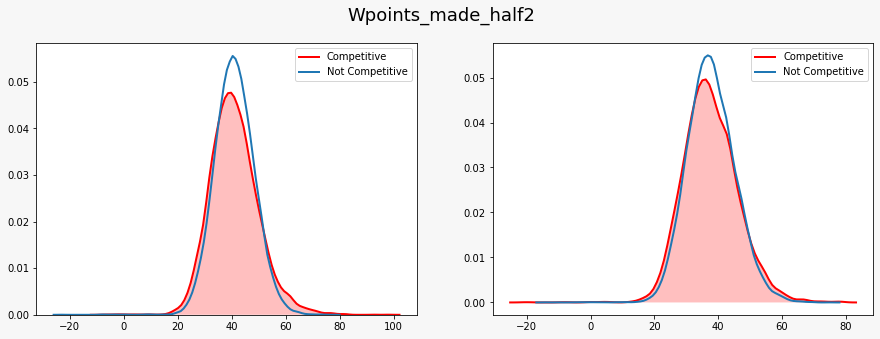

In [186]:
n += 1

competitive_segm(events_m, events_w, events_w.columns[n], events_w.columns[n])